In [1]:
import os
store_dir = '/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/misaligned/new_mis/'
og_evts = '/global/cfs/projectdirs/m3443/data/trackml-kaggle/train_10evts/'
os.environ['TRKXINPUTDIR']=f"{store_dir}shift_x/"
os.environ['TRKXOUTPUTDIR']= f"{store_dir}shift_x_pre/"

In [2]:
import pkg_resources
import yaml
import pprint
import random
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.cm as cm
import sys
import csv
import time
import pickle
import seaborn as sns
# %matplotlib widget

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial

In [3]:
plt.rcParams.update({'axes.titlesize' : 16, 'axes.labelsize' : 16, 'lines.linewidth' : 2, 'lines.markersize' : 10,
                    'xtick.labelsize' : 14, 'xtick.major.width' : 2,
                    'ytick.labelsize' : 14, 'ytick.major.width' : 2,
                    'grid.alpha' : 0.5, "legend.frameon" : False, 'legend.fontsize' : 16})

In [4]:
evtid = 'event000001005'

# No Misalignment

In [5]:
event_path = f"/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/{evtid}"
ogh, ogc, ogp, ogt = trackml.dataset.load_event(event_path)

In [6]:
# g1 = sns.jointplot(ogh.x, ogh.y, s=1, height=12)
# g1.ax_joint.cla()
# plt.sca(g1.ax_joint)

# volumes = ogh.volume_id.unique()
# for volume in volumes:
#     v = ogh[ogh.volume_id == volume]
#     plt.scatter(v.x, v.y, s=1, label='volume {}'.format(volume))
    
# plt.xlabel('X (mm)')
# plt.ylabel('Y (mm)')
# plt.legend(bbox_to_anchor=(1.3, 1), loc='upper left', fontsize=18)
# plt.title('Volume Distribution')
# plt.show()

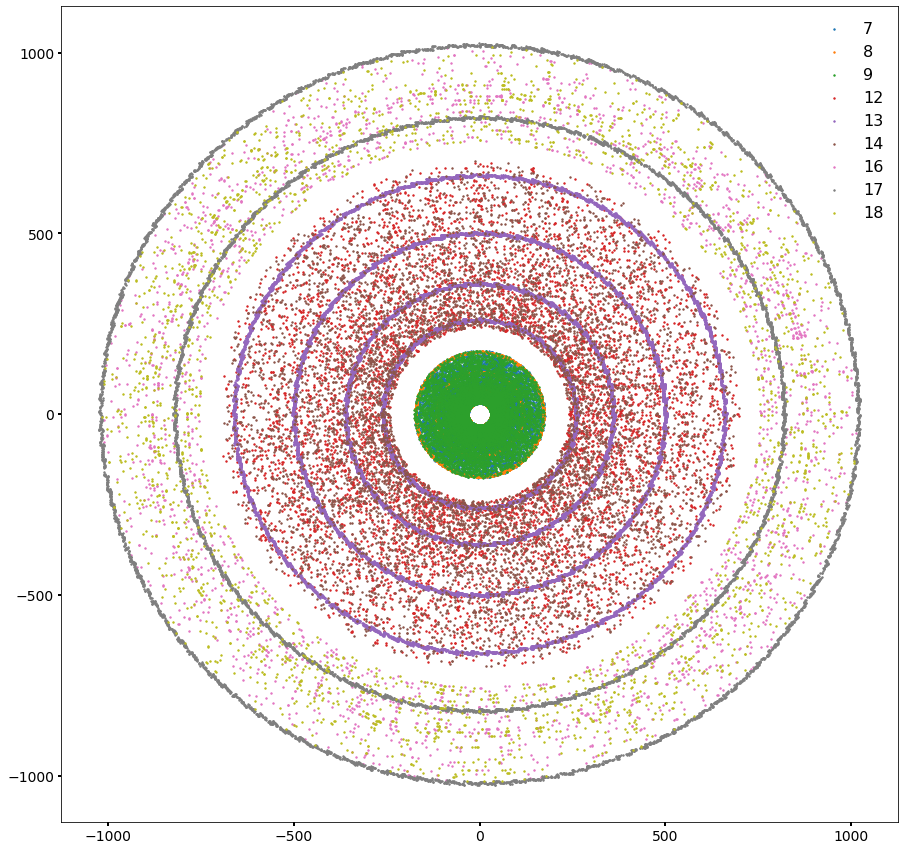

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
volumes = ogh.volume_id.unique()
for volume in volumes:
    v = ogh[ogh.volume_id == volume]
    ax.scatter(v.x,v.y, s=2,label=f"{volume}")
plt.legend()

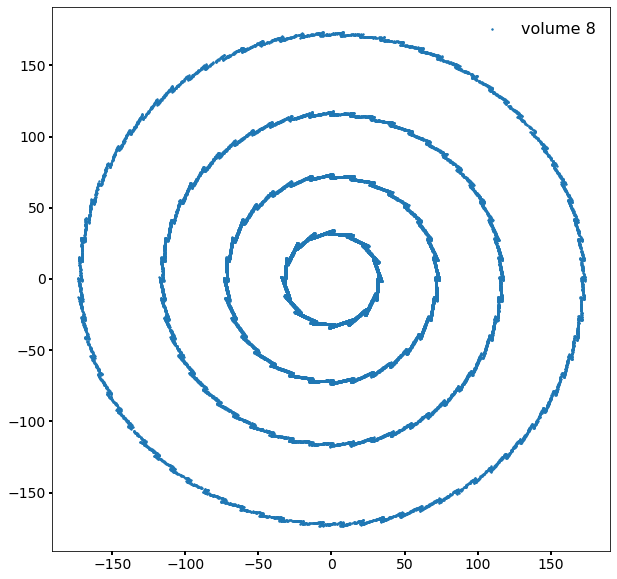

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
v8 = ogh[ogh.volume_id == 8]
ax.scatter(v8.x,v8.y, s=2,label=f"volume 8")
plt.legend()

# Removing volume 8 layer 6

In [9]:
event_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/misaligned/new_mis/remove_v8l6/{evtid}"
hr,cr,pr,tr = trackml.dataset.load_event(event_path)

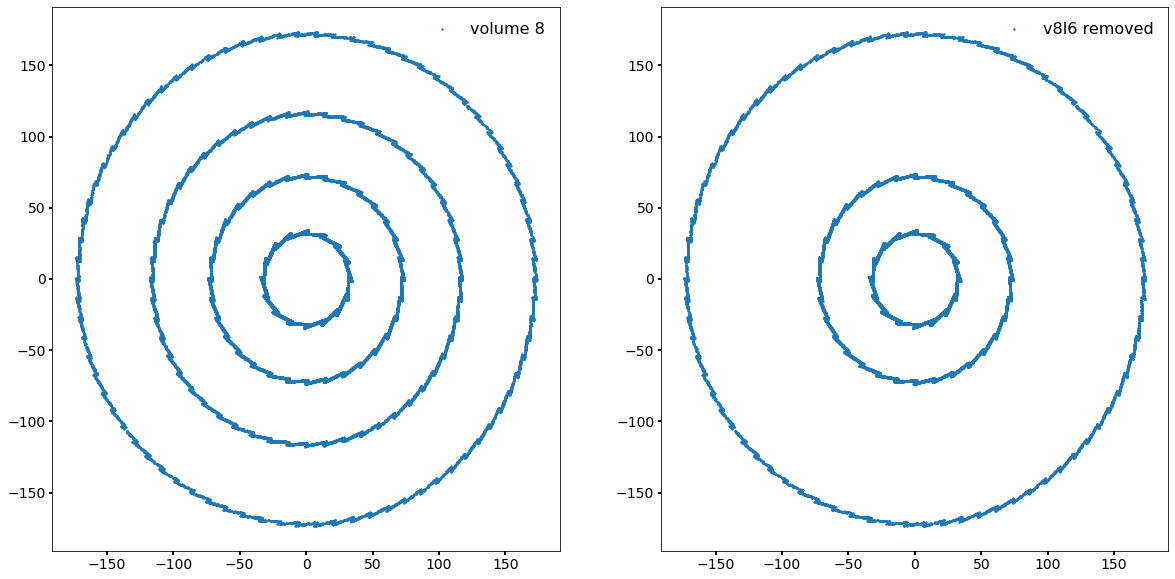

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
remv8 = hr[hr.volume_id == 8]
ax[0].scatter(v8.x,v8.y, s=2,label=f"volume 8")
ax[1].scatter(remv8.x,remv8.y, s=2,label=f"v8l6 removed")
ax[0].legend()
ax[1].legend()

# Shift x coordinate of all hits in volume 8 by 1000 micron

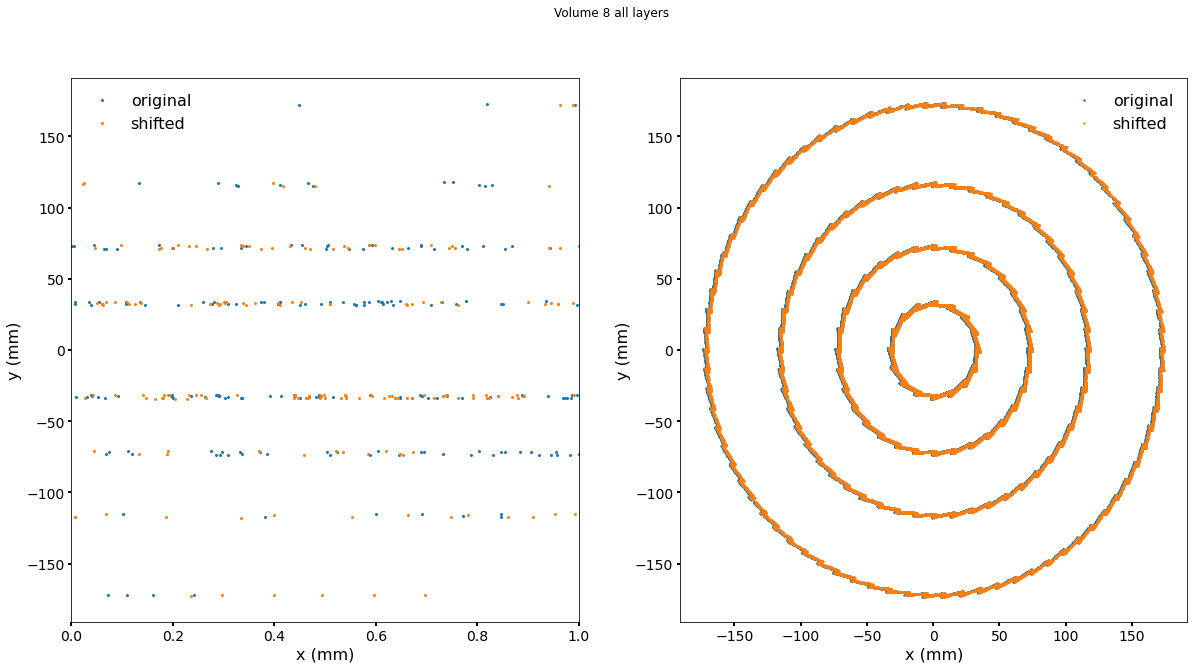

In [11]:
event_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/misaligned/new_mis/shift_x_v8/1/{evtid}"
hsx,csx,psx,tsx = trackml.dataset.load_event(event_path)

fig, ax = plt.subplots(1,2, figsize=(20,10))
sx = hsx[hsx.volume_id == 8]
fig.suptitle("Volume 8 all layers")
ax[0].set_xlim(0,1)
ax[0].scatter(v8.x,v8.y, s=4,label=f"original")
ax[0].scatter(sx.x,sx.y, s=4,label=f"shifted")
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')
ax[0].legend()

ax[1].scatter(v8.x,v8.y, s=2,label=f"original")
ax[1].scatter(sx.x,sx.y, s=2,label=f"shifted")
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
ax[1].legend()

# Shift x coordinate of all hits in event by 1mm

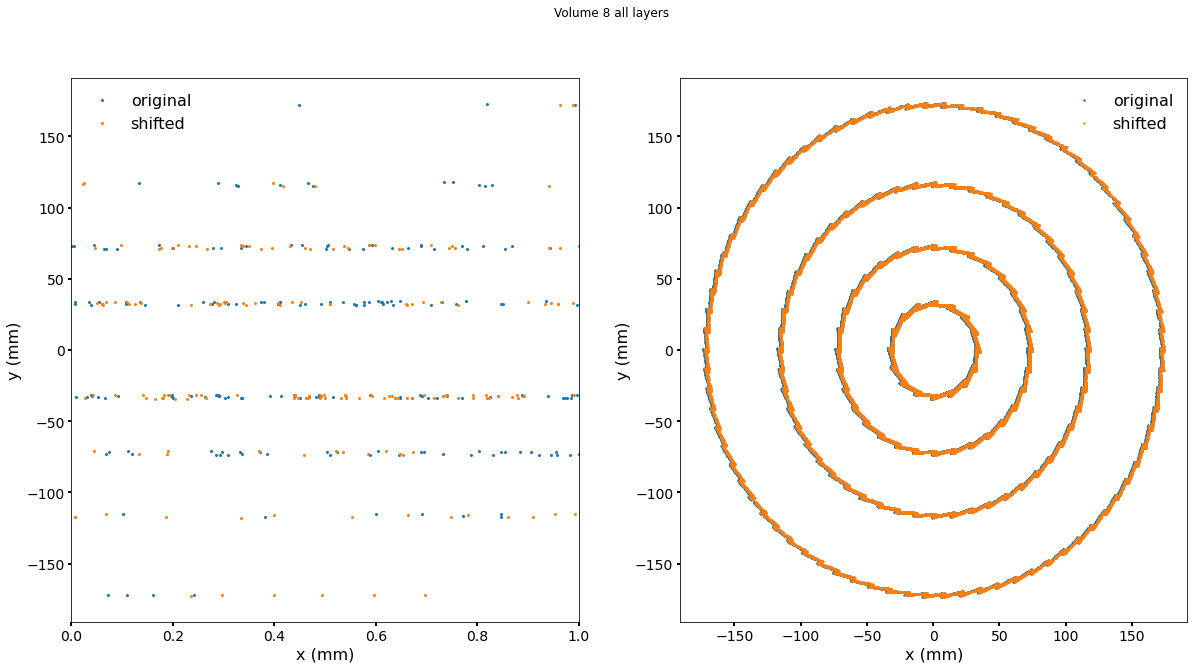

In [12]:
event_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/misaligned/new_mis/shift_x/1/{evtid}"
hx,cx,px,tx = trackml.dataset.load_event(event_path)

fig, ax = plt.subplots(1,2, figsize=(20,10))
allx = hx[hx.volume_id == 8]
fig.suptitle("Volume 8 all layers")
ax[0].set_xlim(0,1)
ax[0].scatter(v8.x,v8.y, s=4,label=f"original")
ax[0].scatter(allx.x,allx.y, s=4,label=f"shifted")
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')
ax[0].legend()

ax[1].scatter(v8.x,v8.y, s=2,label=f"original")
ax[1].scatter(allx.x,allx.y, s=2,label=f"shifted")
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
ax[1].legend()

# Shift x and y coordinates in volume 8 by 1mm

Text(0, 0.5, 'y (mm)')

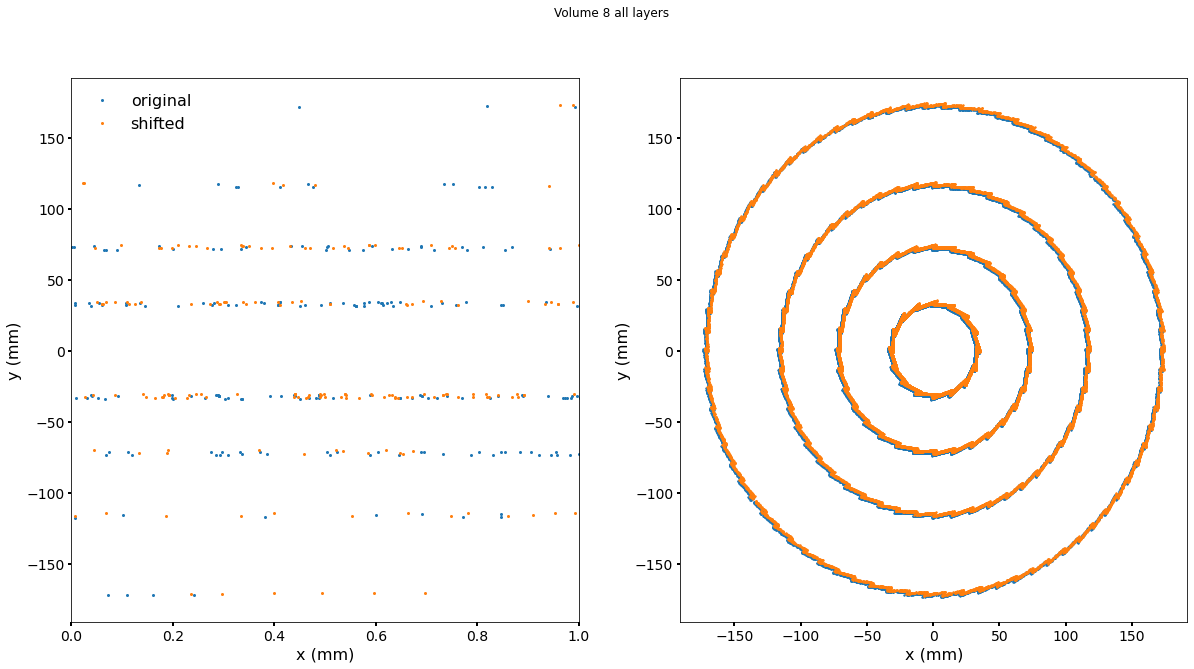

In [16]:
event_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/misaligned/new_mis/shift_xy_v8/1/{evtid}"
hxy,cxy,pxy,txy = trackml.dataset.load_event(event_path)

fig, ax = plt.subplots(1,2, figsize=(20,10))
xy = hxy[hxy.volume_id == 8]
fig.suptitle("Volume 8 all layers")
ax[0].set_xlim(0,1)
ax[0].scatter(v8.x,v8.y, s=4,label=f"original")
ax[0].scatter(xy.x,xy.y, s=4,label=f"shifted")
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')
ax[0].legend()

ax[1].scatter(v8.x,v8.y, s=2,label=f"original")
ax[1].scatter(xy.x,xy.y, s=2,label=f"shifted")
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')

# All Misalignments

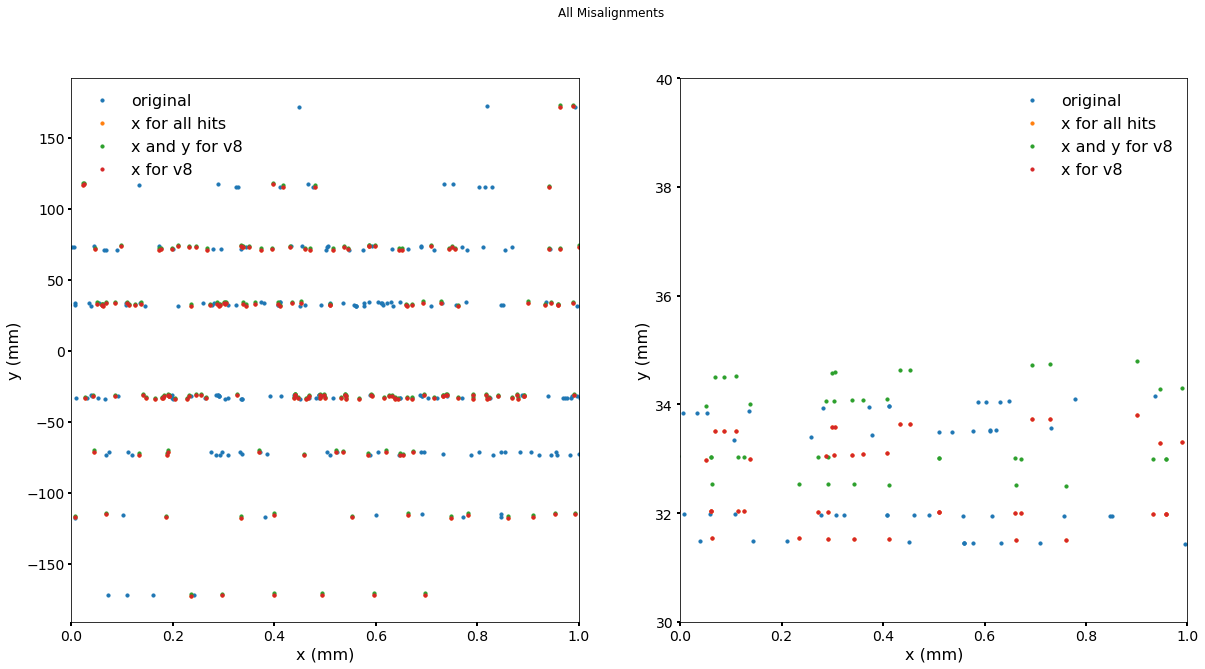

In [21]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("All Misalignments")
ax[0].set_xlim(0,1)
ax[0].scatter(v8.x,v8.y, s=10,label=f"original")
ax[0].scatter(allx.x,allx.y, s=10,label=f"x for all hits")
ax[0].scatter(xy.x,xy.y, s=10,label=f"x and y for v8")
ax[0].scatter(sx.x,sx.y, s=10,label=f"x for v8")
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')
ax[0].legend()

ax[1].set_xlim(0,1)
ax[1].set_ylim(30,40)
ax[1].scatter(v8.x,v8.y, s=10,label=f"original")
ax[1].scatter(allx.x,allx.y, s=10,label=f"x for all hits")
ax[1].scatter(xy.x,xy.y, s=10,label=f"x and y for v8")
ax[1].scatter(sx.x,sx.y, s=10,label=f"x for v8")
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
ax[1].legend()